## 1. Install VJF (for more information, visit https://github.com/catniplab/vjf)

In [1]:
!pip uninstall -y vjf  # uninstall if you have VJF already in order to match the versions 

In [2]:
!rm -rf /tmp/vjf/
!git clone https://github.com/catniplab/vjf.git /tmp/vjf/

Cloning into '/tmp/vjf'...
remote: Enumerating objects: 864, done.
remote: Counting objects: 100% (864/864), done.
remote: Compressing objects: 100% (475/475), done.
remote: Total 864 (delta 556), reused 644 (delta 344), pack-reused 0
Receiving objects: 100% (864/864), 41.71 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (556/556), done.


In [3]:
!git --git-dir=/tmp/vjf/.git --work-tree /tmp/vjf/ checkout 0eec61e91c29cf9a44b48c2a6694234b4404a2b3

Note: switching to '0eec61e91c29cf9a44b48c2a6694234b4404a2b3'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 0eec61e add download link to figshare


In [4]:
import sys
sys.path.append("/tmp/vjf")

## 2. Import the packages / functions

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from tqdm.notebook import trange

import torch
import vjf
from vjf import online

%matplotlib inline

## 3. Import the dataset
### (run ONLY one of the 6 cells below, depending on the dataset you'd like to run with)
- Van der Pol dataset
- Lorenz attractor dataset
- Monkey reach (jPCA) dataset
- Wide-field calcium dataset
- Mouse video dataset
- Neuropixels dataset

#### run the cell below to load the simulated Van der Pol dataset 

In [6]:
# The data loading below is the vdp with (1 trajectory, 2dim, 500 to 20500 time points, with noise sd=0.05)
# Use any of the simulated vdp dataset. 
# You can generate the simulated data using datagen.py (more info in Readme)
data = np.load('vdp_1trajectories_2dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below to load the simulated Lorenz attractor dataset 

In [36]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 20500 time points, with noise sd=0.05)
# Use any of the simulated lorenz dataset. 
# You can generate the simulated data using datagen.py (See README.md for more info)
data = np.load('lorenz_1trajectories_3dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

FileNotFoundError: [Errno 2] No such file or directory: 'lorenz_1trajectories_3dim_500to20500_noise0.05.npz'

#### run the cell below to load the reduced Monkey reach (jPCA) dataset

In [ ]:
# load the reduced Monkey reach dataset (See README.md for how the reduced dataset was generated.)
data = np.load('jpca_reduced.npy')

xs = None  # state
ys = data  # observation
ys = ys[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))  # control input
xdim = 6
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below to load the reduced Wide-field calcium imaging dataset

In [81]:
# load the reduced Wide-field calcium dataset (See README.md for how the reduced dataset was generated.)
data = np.load('widefield_reduced.npy')

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the reduced Mouse video dataset

In [83]:
# load the reduced Mouse video dataset (See README.md for how the reduced dataset was generated.)
data = np.load('reduced_mouse.npy')

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example Neuropixels dataset

In [85]:
# load the reduced Neuropixels dataset with the desired latent dimensions
# (See README.md for how the reduced dataset was generated.)
data = np.load('neuropixel_reduced.npz')['ssSVD10'] # you can change this to 'ssSVD20'

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

## 4. Check your data dimension
It should be
`number of trials x number of time points x number of latent dimensions`

In [7]:
ys.shape

(1, 20000, 2)

## 5. Training the model and calculating the log probs

In [8]:
device = 'cpu'

In [9]:
likelihood = 'gaussian'  # Gaussian observation
dynamics = 'rbf'  # RBF network dynamic model
recognizer = "mlp"  # MLP recognitiom model
rdim = 50  # number of RBFs
hdim = 100  # number of MLP hidden units

mdl = online.VJF(
    config=dict(
        resume=False,
        xdim=xdim,
        ydim=ydim,
        udim=udim,
        Ydim=udim,
        Udim=udim,
        rdim=rdim,
        hdim=hdim,
        lr=1e-3,
        clip_gradients=5.0,
        debug=True,
        likelihood=likelihood,  # 
        system=dynamics,
        recognizer=recognizer,
        C=(None, True),  # loading matrix: (initial, estimate)
        b=(None, True),  # bias: (initial, estimate)
        A=(None, False),  # transition matrix if LDS
        B=(np.zeros((xdim, udim)), False),  # interaction matrix
        Q=(1.0, True),  # state noise
        R=(1.0, True),  # observation noise
    )
).to(device)

{'A': (None, False),
 'B': (array([[0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/Users/nayoungjun/workspace/neuralflow/models',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'rbf',
 'udim': 1,
 'xdim': 2,
 'ydim': 2}
Gaussian likelihood


In [10]:
yy = torch.from_numpy(ys).float().to(device)
uu = torch.from_numpy(us).float().to(device)

q = None

logprobs = []
distances = []

In [11]:
def diagonal_normal_logpdf(mean, variance, sample):
    mean = mean.flatten()
    variance = variance.flatten()
    sample = sample.flatten()
    
    assert len(mean) == len(variance) == len(sample), f"inconsistent shape: {mean.shape}, {variance.shape}, {sample.shape}"
    
    logprobs = []
    for i in range(len(sample)):
        x = sample[i]
        m = mean[i]
        v = variance[i]
        logprobs.append(-0.5 * ((x - m) ** 2 / v + np.log(2 * np.pi * v)))
    return sum(logprobs)


In [12]:
S = 1000  # number of trajectories
T = 10   # length of each trajectory
P = 1   # calculate T-step-ahead predictive distribution every P steps

In [13]:
logprobs = []
logprob_trajectories = []
distances = []
trial = 0


for trial in trange(yy.shape[0]):
    batch_size = 1
    filtering_mu = torch.zeros(batch_size, xdim, device=device)
    filtering_logvar = torch.zeros(batch_size, xdim, device=device)
    q = filtering_mu, filtering_logvar
    logprob_per_trial = []
    logprob_trajectories_per_trial = []
    
    mdl = online.VJF(
        config=dict(
            resume=False,
            xdim=xdim,
            ydim=ydim,
            udim=udim,
            Ydim=udim,
            Udim=udim,
            rdim=rdim,
            hdim=hdim,
            lr=1e-3,
            clip_gradients=5.0,
            debug=True,
            likelihood=likelihood,  # 
            system=dynamics,
            recognizer=recognizer,
            C=(None, True),  # loading matrix: (initial, estimate)
            b=(None, True),  # bias: (initial, estimate)
            A=(None, False),  # transition matrix if LDS
            B=(np.zeros((xdim, udim)), False),  # interaction matrix
            Q=(1.0, True),  # state noise
            R=(1.0, True),  # observation noise
        )
    ).to(device)
    
    for time in trange(yy.shape[1]):

        y = yy[trial, time].unsqueeze(0)
        u = uu[trial, time].unsqueeze(0)
        
        filtering_mu, filtering_logvar = q

        mu_f = filtering_mu[0].detach().cpu().numpy().T
        var_f = filtering_logvar[0].detach().exp().cpu().numpy().T
        Sigma_f = np.eye(xdim) * var_f

        x = multivariate_normal(mu_f.flatten(), Sigma_f).rvs(size=S).astype(np.float32)
        x = torch.from_numpy(x).to(device)
        x += mdl.system.velocity(x) + mdl.system.noise.var ** 0.5 * torch.randn_like(x)
        y_tilde = mdl.decoder(x).detach().cpu().numpy()

        y_var = mdl.likelihood.logvar.detach().exp().cpu().numpy().T
        sample_logprobs = [diagonal_normal_logpdf(y_, y_var, y.cpu().numpy()) for y_ in y_tilde]
        logprob = logsumexp(sample_logprobs) - np.log(S)

        logprob_per_trial.append(logprob)
        distances.append(np.linalg.norm(y_tilde - y[0].cpu().numpy(), axis=-1).mean())
        
        
        if time % P == 0 and time + T < yy.shape[1]:
            # rolling-predict T-1 more steps
            trajectory_logprobs = [logprob]
            
            
            for tprime in range(time + 1, time + T):
                y_tprime = yy[trial, tprime].unsqueeze(0)
                u_tprime = uu[trial, tprime].unsqueeze(0)
                
                x += mdl.system.velocity(x) + mdl.system.noise.var ** 0.5 * torch.randn_like(x)
                y_tilde = mdl.decoder(x).detach().cpu().numpy()
                # y_var didn't change
                
                # cumulative sum on sample logprobs
                new_sample_logprobs = [diagonal_normal_logpdf(y_, y_var, y_tprime.cpu().numpy()) for y_ in y_tilde]
                sample_logprobs = [a + b for a, b in zip(sample_logprobs, new_sample_logprobs)]
                
                logprob = logsumexp(sample_logprobs) - np.log(S)
                trajectory_logprobs.append(logprob)
                
            logprob_trajectories_per_trial.append(trajectory_logprobs)

        q, loss = mdl.feed((y, u), q)

    logprobs.append(logprob_per_trial)
    logprob_trajectories.append(logprob_trajectories_per_trial)

  0%|          | 0/1 [00:00<?, ?it/s]

{'A': (None, False),
 'B': (array([[0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/Users/nayoungjun/workspace/neuralflow/models',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'rbf',
 'udim': 1,
 'xdim': 2,
 'ydim': 2}
Gaussian likelihood


  0%|          | 0/20000 [00:00<?, ?it/s]

## 6. Save the log probabilities 

In [20]:
np.save('logprob_vjf_lorenz_0.05.npy', np.array(logprob_trajectories[0]))

## 7. Plotting the log probability 

In [38]:
trajectory_logprobs = np.load('logprob_vjf_lorenz_0.05.npy')

In [39]:
import pandas as pd
def ewma(data, com):
    return np.array(pd.DataFrame(data=dict(data=data)).ewm(com).mean()['data'])

(-2.0, 2.0)

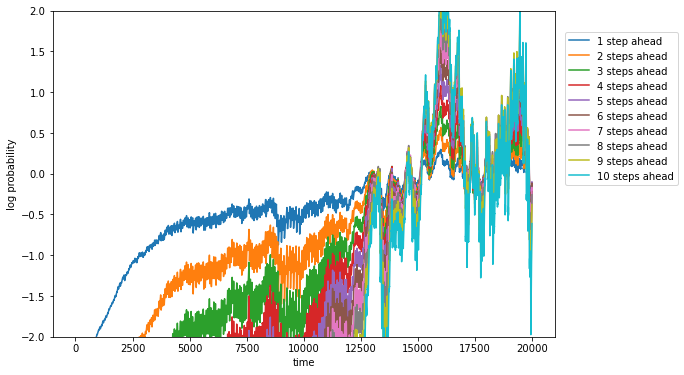

In [52]:
plt.figure(figsize=(9, 6))

for i in range(trajectory_logprobs.shape[-1]):
    curve = ewma(trajectory_logprobs[:, i], 100)
    plt.plot(np.arange(len(curve)) * P, curve, label=f"{i+1} step{'s' if i > 0 else ''} ahead")
    
plt.legend(bbox_to_anchor=(1.01, 0.95))
plt.ylabel("log probability")
plt.xlabel("time")
plt.ylim([-2, 2])

## 8. Compute the mean and std of the last half of the time points (for Table 1)

In [46]:
nn = trajectory_logprobs.shape[0]
for i in range(10):
    print(f"{i+1} step:", trajectory_logprobs[nn//2:, i].mean(), trajectory_logprobs[nn//2:, i].std())

1 step: -0.09206914916051928 0.46755113129434306
2 step: -0.16165609190293986 0.8262654404427056
3 step: -0.22268971047118918 1.1511026136055789
4 step: -0.27348206459820085 1.4568003992448408
5 step: -0.3219829688399637 1.7600829980145463
6 step: -0.3789003444909611 2.0804858995652555
7 step: -0.45961054896524156 2.444362432478006
8 step: -0.57146432543136 2.8371904319146863
9 step: -0.7299886841183005 3.290022236728938
10 step: -0.9590682087453751 3.824620091176863
